In [20]:
import os
import random
import time
import datetime
import copy
import itertools

import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn.functional as F
from torch import nn, optim

from torch.utils.data import Subset
from torch.optim import lr_scheduler 

import torchvision
from torchvision import transforms, models, datasets, utils

import splitfolders

In [21]:
torch.cuda.is_available()

# Verifica se a GPU está disponível
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print('\nDevice: {0}'.format(device))

# print(torch.cuda.get_device_name(0))

# !nvidia-smi

SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

In [22]:
def initialize_model(model_name, num_classes):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(weights='DEFAULT')
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(weights='DEFAULT')
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(weights='DEFAULT')
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(weights='DEFAULT')
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(weights='DEFAULT')
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(weights='DEFAULT')
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [23]:
# base_dir = 'data\RoCole\sorted_binary'

# # Split with a ratio.
# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# splitfolders.ratio(base_dir, output="splited", seed=42, ratio=(.8, .1, .1)) # default values (.8, .1, .1)
# print("Splits Ok!")

In [24]:
# Define o caminho base do diretório de imagens divididas 
base_dir = 'data\splited\\'

# Número de classes
num_classes = 2

# Nomes das classes
class_names = ['healthy', 'unhealthy']

# Tamanho do lote (mini-batch)
batch_size = 32

# Taxa de aprendizado
lr = 0.001

# Mommentum
mm = 0.9

# Número de épocas
epochs = 50 # Usar durante o desenvolvimento
### epochs = 50 

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "alexnet"

model_ft, input_size = initialize_model(model_name, num_classes)

In [25]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(base_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}


Initializing Datasets and Dataloaders...


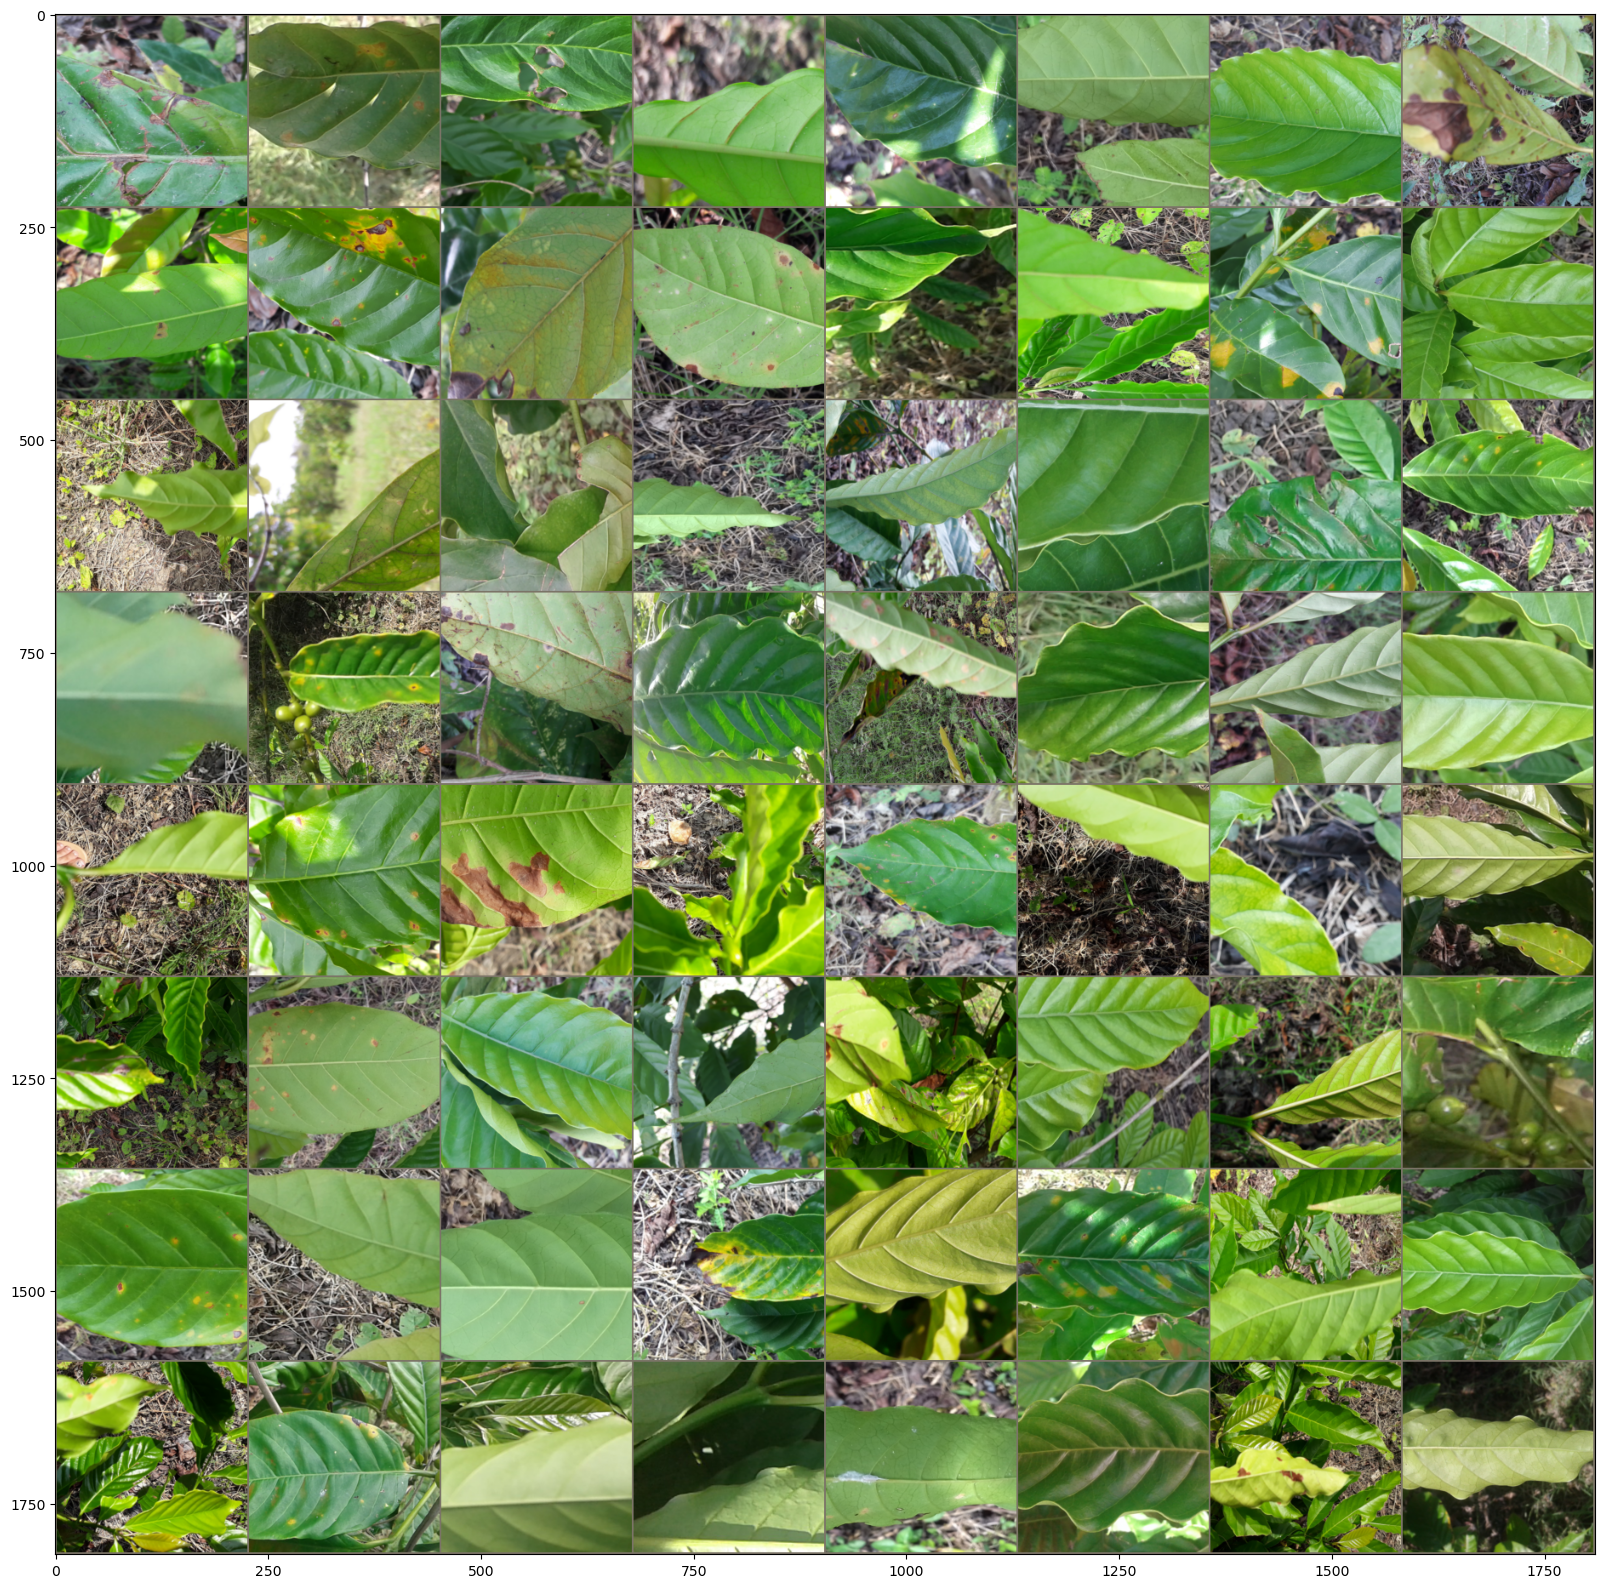

In [26]:
def show_transformed_image(image):
    # Unnormalize all channels 
    ### for t, m, s in zip(np_image, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
    for t, m, s in zip(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]): # (ImageNet weights)       
        t.mul_(s).add_(m)

    np_image = image.numpy()

    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

# Visualizar 'batch_size' imagens
dataloader_vis = torch.utils.data.DataLoader(dataset=image_datasets['train'], shuffle=True, batch_size=64)
items = iter(dataloader_vis)
image, label = next(items)

show_transformed_image(utils.make_grid(image))

In [27]:
# Número de imagens em cada dataset
train_size = 0
val_size = 0
test_size = 0

for name, data in image_datasets.items():
    if name == 'train':
        train_size = len(data)
    elif name == 'val':
        val_size = len(data)
    else:
        test_size = len(data)

    print(f'Data set: {name}. Size: {len(data)}')


Data set: train. Size: 1247
Data set: val. Size: 155
Data set: test. Size: 158


In [28]:
# Pretrainned
model_ft = model_ft.to(device)

# Função de perda
criterion = nn.CrossEntropyLoss()

# Otimizador
optimizer = optim.SGD(model_ft.parameters(), lr=lr, momentum=mm)
  
# Imprime o modelo
print(str(model_ft))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
def evaluate_model(model, dataloader, device):
    y_true = []
    y_pred = []
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true += labels.tolist()
            y_pred += predicted.tolist()

    return y_true, y_pred

In [30]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:
def plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs, model_name, date_now, save_dir):
    """
    Plota gráfico de loss e accuracy por epoch para conjunto de treinamento e validação
    
    Args:
        train_losses (list): Lista com os valores de loss do conjunto de treinamento por epoch
        val_losses (list): Lista com os valores de loss do conjunto de validação por epoch
        train_accs (list): Lista com os valores de accuracy do conjunto de treinamento por epoch
        val_accs (list): Lista com os valores de accuracy do conjunto de validação por epoch
    
    Returns:
        None
    """
    # Define o número de epochs
    epochs = len(train_losses)
    
    # Define o eixo x do gráfico como o número de epochs
    x = range(1, epochs + 1)
    
    # Plota os gráficos de loss e accuracy para conjunto de treinamento e validação
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, train_losses, c='magenta' ,ls='--', label='Train loss', fillstyle='none')
    plt.plot(x, val_losses, c='green' ,ls='--', label='Val. loss', fillstyle='none')
    plt.title('Loss por epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, [acc.cpu() for acc in train_accs], c='magenta' ,ls='-', label='Train acuracy', fillstyle='none')
    plt.plot(x, [acc.cpu() for acc in val_accs], c='green' ,ls='-', label='Val. accuracy', fillstyle='none')
    plt.title('Accuracy por epoch')
    plt.legend()
    
    plt.savefig(f'{save_dir}/{model_name}_loss_acc_{date_now}.pdf')
    plt.show()

In [32]:
def generate_classification_report(model, dataloader,class_name, device='cpu'):
    # Define o modelo para o dispositivo correto (CPU ou GPU)
    model = model.to(device)
    model.eval()
    
    # Inicializa as variáveis de predições e rótulos verdadeiros
    all_preds = torch.tensor([], dtype=torch.long, device=device)
    all_labels = torch.tensor([], dtype=torch.long, device=device)

    # Realiza a predição para cada lote de dados no dataloader
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Adiciona as predições e rótulos verdadeiros às variáveis criadas anteriormente
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)
    
    # Gera o classification report com base nas predições e rótulos verdadeiros
    report = metrics.classification_report(all_labels.cpu().numpy(), all_preds.cpu().numpy(),target_names=class_names,
                                           digits=4, zero_division=0)
    
    return report

In [33]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, batch_size, device='cpu', model_name='model'):
    
    # Tempo total do treinamento (treinamento e validação)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    # Cria a pasta com o nome do modelo
    output_dir = 'outputs\\' + model_name
    os.makedirs(output_dir, exist_ok=True)

    date_now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    # Cria a pasta para separar os testes
    result_dir = output_dir + '\\' + model_name +'_' + date_now
    os.makedirs(result_dir, exist_ok=True)

    # Abre o arquivo para salvar o resultado
    f = open(f'{result_dir}/{model_name}_{date_now}.txt', 'w')
    
    for epoch in range(num_epochs):
        f.write(f'Epoch {epoch}/{num_epochs - 1}\n')
        f.write('-' * 10 + '\n')

        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            # Inicia contagem de tempo da época
            time_epoch_start = time.time()

            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Perda (loss) nesta época
            running_loss = 0.0
            # Amostras classificadas corretamente nesta época
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if model_name == 'inception' and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Atualiza a perda da época
                running_loss += loss.item() * inputs.size(0)
                # Atualiza o número de amostras classificadas corretamente na época.
                running_corrects += torch.sum(preds == labels.data)
            # Perda desta época
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # Acurácia desta época
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # Tempo total desta época
            time_epoch = time.time() - time_epoch_start

            f.write(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ({time_epoch:.4f} seconds) \n')

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ({time_epoch:.4f} seconds)')

            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
            else:
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        time_epoch = time.time() - since

        f.write(f'Time: {time_epoch:.0f}s\n')
        f.write('\n')

        print(f'Time: {time_epoch:.0f}s')
        print('\n')

    time_elapsed = time.time() - since
    f.write(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s\n')
    f.write(f'Number of epochs: {num_epochs}. Batch size: {batch_size}\n')
    f.write(f'Best val loss: {best_loss:.4f} Best val acc: {best_acc:.4f}\n')

    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:.4f} Best val acc: {best_acc:.4f}')

    # Save the confusion matrix
    y_true, y_pred = evaluate_model(model, dataloaders['val'], device=device)
    # Confusion matrix
    conf_mat_val = metrics.confusion_matrix(y_true, y_pred)
    f.write(f'\nConfusion Matrix:\n{conf_mat_val}\n')

    print(f'Confusion Matrix:\n{conf_mat_val}')

    # Classification report 
    class_rep_val = generate_classification_report(model_ft, dataloaders_dict['val'],model_name, device)    
    f.write(f'\nClassification report:\n{class_rep_val}\n')


    f.close()

    # Save the plot
    plt.figure()
    plot_confusion_matrix(conf_mat_val, classes=class_names)
    plt.savefig(f'{result_dir}/{model_name}_cf_mat_{date_now}.pdf')

    #Plota gráfico de loss e accuracy por epoch
    plot_loss_accuracy(train_loss_list, val_loss_list, train_acc_list, val_acc_list, model_name, date_now, result_dir)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Epoch 0/49
----------
train Loss: 0.5660 Acc: 0.7017 (15.6713 seconds)
val Loss: 0.3059 Acc: 0.9032 (4.8404 seconds)
Time: 21s


Epoch 1/49
----------
train Loss: 0.3639 Acc: 0.8436 (15.4097 seconds)
val Loss: 0.2193 Acc: 0.9097 (4.3552 seconds)
Time: 40s


Epoch 2/49
----------
train Loss: 0.2973 Acc: 0.8741 (15.0617 seconds)
val Loss: 0.1288 Acc: 0.9742 (4.2679 seconds)
Time: 60s


Epoch 3/49
----------
train Loss: 0.2514 Acc: 0.9046 (15.0887 seconds)
val Loss: 0.1096 Acc: 0.9742 (4.4240 seconds)
Time: 79s


Epoch 4/49
----------
train Loss: 0.2227 Acc: 0.9094 (15.5141 seconds)
val Loss: 0.1012 Acc: 0.9677 (4.1306 seconds)
Time: 99s


Epoch 5/49
----------
train Loss: 0.2143 Acc: 0.9238 (15.2679 seconds)
val Loss: 0.1042 Acc: 0.9806 (4.3870 seconds)
Time: 118s


Epoch 6/49
----------
train Loss: 0.2136 Acc: 0.9190 (15.1278 seconds)
val Loss: 0.1486 Acc: 0.9484 (4.1288 seconds)
Time: 138s


Epoch 7/49
----------
train Loss: 0.2305 Acc: 0.9062 (14.8891 seconds)
val Loss: 0.1129 Acc: 0.

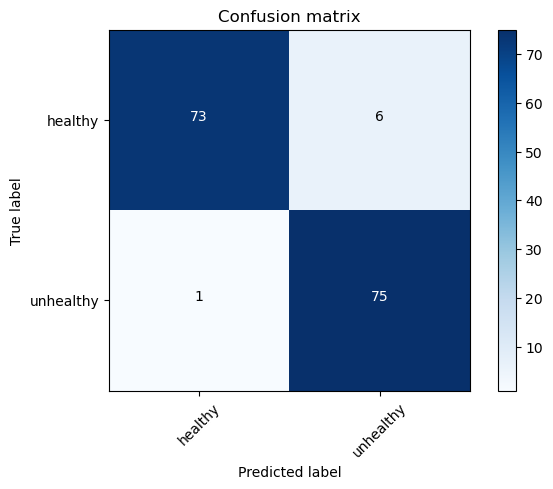

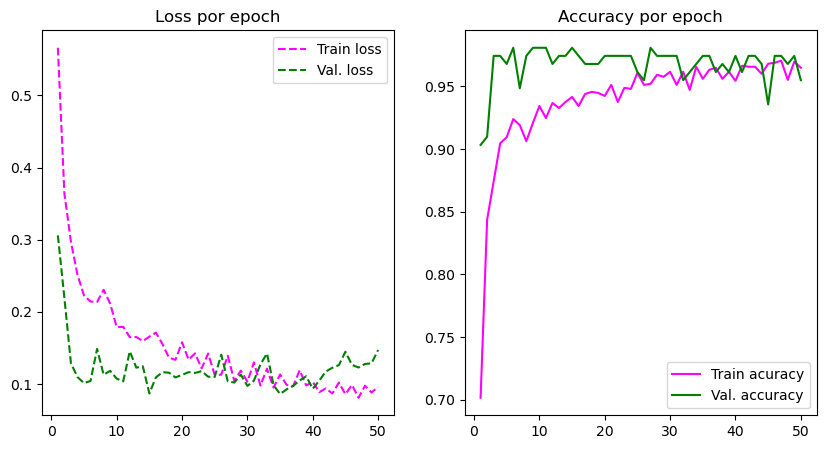

In [34]:
model_ft = train_model(model_ft, dataloaders_dict, criterion, optimizer, epochs, batch_size, device, model_name)

In [35]:
# # Define o número de folds
# num_folds = 5

# # Cria os dataloaders para cada fold
# kfold_dataloaders = []
# skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
# for train_idx, val_idx in skf.split(image_datasets['train'], image_datasets['train'].targets):
#     train_dataset = Subset(image_datasets['train'], train_idx)
#     val_dataset = Subset(image_datasets['train'], val_idx)
#     train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
#     val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
#     kfold_dataloaders.append({'train': train_dataloader, 'val': val_dataloader})

# # Treina o modelo usando os dataloaders de cada fold
# for fold, dataloaders in enumerate(kfold_dataloaders):
#     print(f"Training fold {fold + 1}")
#     model = train_model(model_ft, dataloaders, criterion, optimizer, num_epochs=epochs, device=device, model_name=f"{model_name}{fold + 1}")

In [36]:
# model.eval()
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for images, labels in dataloaders_dict['test']:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# accuracy = 100 * correct / total
# print('Accuracy on test set: {:.2f}%'.format(accuracy))


In [37]:
# # Lista com as classes reais e classes preditas
# true_val_list = []
# pred_val_list = []
# # Lista com as probabilidades
# prob_val_list = []

# # Iterate along the batches of the VALIDATION SET
# for i, (img_list, labelList) in enumerate(dataloaders_dict['val']):

#     # if DEVICE.type == 'cuda':
#     img_list = img_list.to(device)
#     labelList = labelList.to(device)

#     # Desabilita o cálculo do gradiente durante validação e testes.
#     torch.set_grad_enabled(False) 

#     # -----> FORWARD
#     # Saída do modelo
#     outputs = model_ft(img_list)

#     # Predição
#     ### _, preds = torch.max(output, 1)
#     preds = torch.argmax(outputs, dim=1)

#     # Calcula probabilidades 
#     # https://discuss.pytorch.org/t/obtain-probabilities-from-cross-entropy-loss/157259
#     outputs_prob = nn.functional.softmax(outputs, dim=1)
#     prob_val_batch = np.asarray(outputs_prob.cpu())

#     # Classes reais true) e classes preditas (pred) para este lote.
#     # if DEVICE.type == 'cuda':
#     true_val_batch = np.asarray(labelList.cpu())
#     pred_val_batch = np.asarray(preds.cpu())
        
#     # Itera ao longo do lote
#     for i in range(0, len(pred_val_batch)):
#         true_val_list.append(true_val_batch[i])
#         pred_val_list.append(pred_val_batch[i])

#         prob_val_list.append(prob_val_batch[i])

# # Confusion matrix
# conf_mat_val = metrics.confusion_matrix(true_val_list, pred_val_list)
# print('\nConfusion matrix ( validation)')
# print(conf_mat_val)

# # Classification report - Scikit-learn
# class_rep_val = metrics.classification_report(true_val_list, pred_val_list, 
#                                               target_names=class_names, digits=4,
#                                               zero_division=0)
# print('\nClass. report (validation)')
# print(class_rep_val)

# # Accuracy
# acc_val = metrics.accuracy_score(true_val_list, pred_val_list)
# print('\n\nValidation Acc.: {:.4f}'.format(acc_val))

In [38]:
# # Confusion matrix
# conf_mat_val = metrics.confusion_matrix(true_val_list, pred_val_list)
# print('\nConfusion matrix ( validation)')
# print(conf_mat_val)

# # Classification report - Scikit-learn
# class_rep_val = metrics.classification_report(true_val_list, pred_val_list, 
#                                               target_names=class_names, digits=4,
#                                               zero_division=0)
# print('\nClass. report (validation)')
# print(class_rep_val)

# # Accuracy
# acc_val = metrics.accuracy_score(true_val_list, pred_val_list)
# print('\n\nValidation Acc.: {:.4f}'.format(acc_val))